# Federico Campanozzi - Progetto Data Intensive con Relazione
a.a. 2021/2022

## 1 - Descrizione del problema

L'obiettivo del progetto è quello di creare un modello predittivo che, data una transazione, determini se è lecita oppure no. Per fare ciò abbiamo a disposizione un dataset con circa $\approx\,6\,\cdot\,10^6$ di esempi etichettati. 

Il modello da creare sarà quindi un modello di classificazione binario, cioè con sole due classi 1 se è una transazione illecita e 0 altrimenti.

### 1.1 - Descrizione del Dataset

Le colonne del dataset sono così definite : 
- step: rappresenta un'unita di tempo 1 = 1 ora.
- type: tipo di transazione.
- amount: quanto denaro viene spostato.
- nameOrig: codice del cliente che inizia l'operazione di transazione.
- oldbalanceOrg: denaro nel cc del mittente.
- newbalanceOrig: denaro nel cc del mittente alla fine della transazione.
- nameDest: codice cliente del beneficiario.
- oldbalanceDest: denaro nel cc del beneficiario prima che la transazione avesse inizio.
- newbalanceDest: denaro nel cc del destinatario dopo la transazione.
- isFraud: 1 se la transazione è stato etichettata come illecita 0 altrimenti.
- isFlaggedFraud : il risultato del modello predittivo.

## 2- Analisi esplorativa

Importiamo le librerie di base.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Partiamo con l'importare il dataset in un DataFrame pandas.

In [2]:
transactions = pd.read_csv("../data/data.csv")
print(f"Dimensioni del dataset : {transactions.values.shape}")
transactions.drop(columns=["isFlaggedFraud"])[:10]

Dimensioni del dataset : (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0


Estraiamo, con il metodo *describe*, dal DataFrame tutte le statistiche utili al fine di capire le feature che possiamo usare e le feature che è meglio "accantonare". Ho usato il parametro *include='all'* poichè nel dataset ci sono variabili categoriche (i.e. nameDest) e quindi pandas può non restituire alcune righe (i.e. unique, top e altre) che invece mi interessa sapere. *include='all'* permette appunto di includere i valori mancanti (NaN).

In [3]:
transactions.drop(columns=["isFlaggedFraud"]).describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00


Determiniamo, grazie al metodo *corr*, la matrice di correlazione per capire quali feature sono maggiormente correlate ad altre. A titolo di esempio usiamo la correlazione di pearson.

In [4]:
transactions.drop(columns=["isFlaggedFraud"]).corr(method='pearson')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


Possiamo notare che le feature maggiorment correlate sono :

In [5]:
feature_list = ["type","amount","oldbalanceOrg","newbalanceOrig"]

Purtroppo il metodo *corr* non supporta nativamente il calcolo della correlazione per le variabili categoriche, quindi ho aggiunto alla *feature_list* anche la variabile categorica "type" (vediamo dopo il perchè). 

Le variabili categoriche *nameOrig* e *nameDest* sono state scartate perchè altamente variabili e non continue, quindi non direttamente utilizzabili. Ho escluso la variabile *step* perchè difficilmente utilizzabile sia come var. categorica sia come var. numerica.

In generale è sempre possibile utilizzare le variabili costruendo dei metodi "ad hoc" per raggrupparle, in questo progetto non ho trovato un metodo che facesse al caso mio.

### 2.1 - Grafici

I seguenti grafici hanno lo scopo di far capire quanto il "tipo transazione" (variabile categorica "type") è importante nel nostro studio (quindi anche il perchè è stata inclusa nella *feature_list*) e lo sbilanciamento della var. binaria da predire *isFraud*.

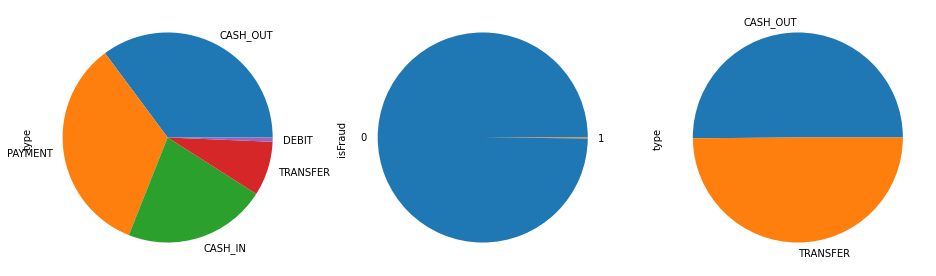

In [6]:
plt.figure(figsize=(16, 10))
transactions["type"].value_counts().plot.pie(ax=plt.subplot(1, 3, 1));
transactions["isFraud"].value_counts().plot.pie(ax=plt.subplot(1, 3, 2));
transactions[transactions["isFraud"] == 1]["type"].value_counts().plot.pie(ax=plt.subplot(1, 3,3));

Per visualizzare su un grafico a dispersione la correlazione delle feature si può procedere in diversi modi. Quello proposto in questo progetto è la creazione di n grafici che combinano 2 feature alla volta. Questo approccio può andare bene se il numero di feature è ridotto (<10) altrimenti bisogna procedere a buon senso (i.e. basandosi sulla matrice di correlazione) creando manualmente i grafici.

Per questa parte uso un dataset ridotto per limitare il tempo di calcolo dei grafici e perchè quello che vogliamo è un'indicazione generale.

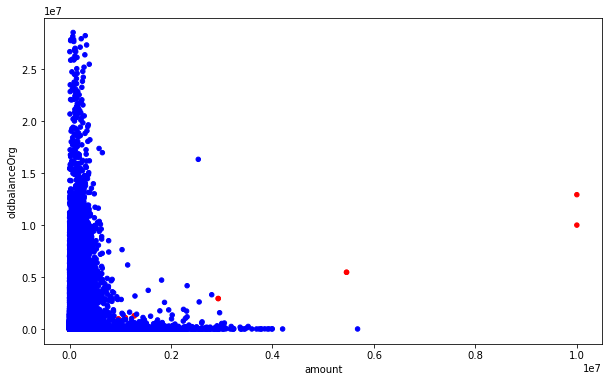

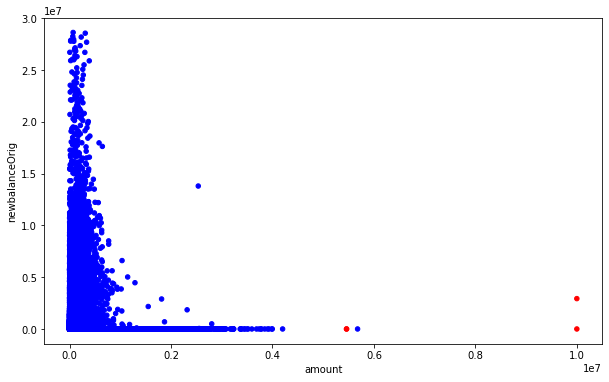

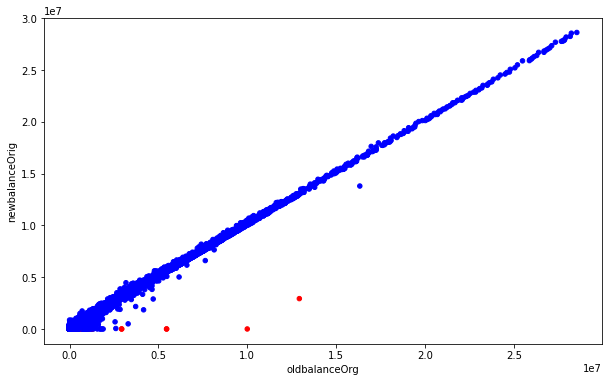

In [7]:
transactions = pd.read_csv("../data/data.csv", nrows=40_000)
tfraut_colors = transactions["isFraud"].map({0: "blue", 1: "red"})
for f_i in range(1, len(feature_list)):
     for f_j in range(f_i + 1, len(feature_list)) :        
        transactions.plot.scatter(feature_list[f_i], feature_list[f_j], c=tfraut_colors, figsize=(10, 6));

## 3 - Normalizzazione dei dati

Iniziamo col dividere le feature in due gruppi (perchè poi andranno trattate diversamente):
   - Feature Numeriche : Applicheremo una **normalizzazione** per avere la stessa scala.
   - Feature Categoriche : Applicheremo una **binarizzazione** che sotituisce ogni singola colonna categorica con n colonne binarie, dove n indica il numero distinto di valori. In questo dataset, come anche anticipato nel punto 1, l'unica var. facilmente utilizzabile è "type" che produrrà 5 var. binarie.

In [8]:
feature_numeric = ["amount","oldbalanceOrg","newbalanceOrig"]
feature_categorical = ["type"]

Grazie alla classe *ColumnTransformer* possiamo applica entrambe queste trasformazioni in modo semplice e in *Pipeline*. Memorizzo l'oggeto in una variabile così lo posso riutilizzare successivamente per la creazione dei modelli di learning.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

X = transactions[feature_list]
y = transactions[["isFraud"]]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=43)

preproc = ColumnTransformer([
    ("numeric",StandardScaler(),feature_numeric),
        ("categorical",OneHotEncoder(),feature_categorical)
    ],remainder="drop")

Vediamo, a titolo di esmpio, come cambia il daset visualizzando i primi 10 record.

In [10]:
X_sample = transactions[feature_numeric + feature_categorical]
preproc.fit_transform(X_sample)
f_names = feature_numeric + list(preproc.named_transformers_["categorical"].get_feature_names())
pd.DataFrame(
    preproc.transform(X_sample),
    columns = f_names
).head(10)

,amount,oldbalanceOrg,newbalanceOrig,x0_CASH_IN,x0_CASH_OUT,x0_DEBIT,x0_PAYMENT,x0_TRANSFER
0,-0.439241,-0.266896,-0.273043,0.0,0.0,0.0,1.0,0.0
1,-0.464742,-0.331287,-0.333001,0.0,0.0,0.0,1.0,0.0
2,-0.470125,-0.340399,-0.341250,0.0,0.0,0.0,0.0,1.0
3,-0.470125,-0.340399,-0.341250,0.0,1.0,0.0,0.0,0.0
4,-0.433394,-0.322506,-0.328533,0.0,0.0,0.0,1.0,0.0
5,-0.445706,-0.317184,-0.321659,0.0,0.0,0.0,1.0,0.0
6,-0.447976,-0.261248,-0.266324,0.0,0.0,0.0,1.0,0.0
7,-0.445566,-0.264322,-0.269670,0.0,0.0,0.0,1.0,0.0
8,-0.457835,-0.339322,-0.341250,0.0,0.0,0.0,1.0,0.0
9,-0.453636,-0.322434,-0.325769,0.0,0.0,1.0,0.0,0.0


### 3.1 - SVD

Per rappresentare tutte le feature in un unico grafico si può utilizzare la decomposizione **SVD** (Single Value Decomposition) che trasforma una spazio k-dimensionale in uno spazio n-dimensionale.

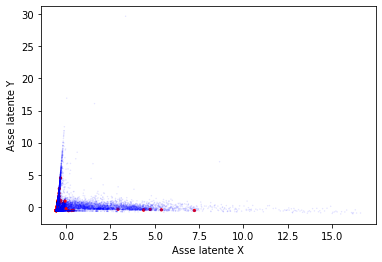

In [11]:
from sklearn.decomposition import PCA

pca = PCA()

color_map = transactions[:X_train.values.shape[0]]["isFraud"].map({0: "blue", 1: "red"})
size_map = transactions[:X_train.values.shape[0]]["isFraud"].map({0: 0.25, 1:5.0})
alpha_blend_map = transactions[:X_train.values.shape[0]]["isFraud"].map({0: 0.1, 1:1})
x_preproc = pca.fit_transform(preproc.fit_transform(X_train))

plt.scatter(x_preproc[:,0], x_preproc[:,1], c=color_map, s=size_map, alpha=alpha_blend_map)
plt.xlabel('Asse latente X')
plt.ylabel('Asse latente Y')
plt.show()

## 4 - Modelli di Learning

Data il grande numero di istanze di questo dataset per contenere drasticamente i tempi di calcolo limito il dataset a $10^5$ istanze.

In [12]:
from sklearn.pipeline import Pipeline

transactions = pd.read_csv("../data/data.csv", nrows=100_000)
classes = ["isFraud", "Honest"]

X = transactions[feature_list]
y = transactions[["isFraud"]]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=43)

Predisponiamo inoltre alcune "utility function" che migliorano la leggibilità del codice e la riusabilità.

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def print_eval(X, y, model, classes):
    '''print eval for classification model'''
    y_pred = model.predict(X)    
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix : ")
    print_matrix(classes, cm)
    print(f"\nPRECISION  : {precision_score(y, y_pred):12.4f}")
    print(f"RECALL     : {recall_score(y, y_pred):12.4f}")
    print(f"F1-MEASURE : {f1_score(y, y_pred, average='macro'):12.4f}")
    print(f"R^2        : {model.score(X,y):12.4f}")
    return None

def print_matrix(classes, matrix, pad = 10):
    '''This method prints a matrix with better formatting.
    Is used for print n x n confusion matrix'''
    for i in range(len(classes)):
        if i == 0 : 
            for c in ([" "] + classes):
                print(f"{c.rjust(pad, ' ')}",end=' ')
            print()
        for j in range(len(classes)):
            if (j == 0) : 
                print(f"{classes[i].rjust(pad, ' ')}",end=' ')
            print(f"{str(matrix[i][j]).rjust(pad, ' ')}",end=' ')
        print()
    return None

### 4.1 Perceptron

Come primo modello analizziamo il *Perceptron*.

In [14]:
from sklearn.linear_model import Perceptron
model = Pipeline([
    ("preproc", preproc),
    ("Perceptron",  Perceptron(random_state=43,class_weight={1:45}))
])
model.fit(X_train, y_train.values.ravel())
print_eval(X_val, y_val.values.ravel(), model, classes)

Confusion Matrix : 
              isFraud     Honest 
   isFraud      33226         62 
    Honest         37          9 

PRECISION  :       0.1268
RECALL     :       0.1957
F1-MEASURE :       0.5762
R^2        :       0.9970


Data la sua semplicità abbiamo una precisione molto bassa in quanto la F1-MEASURE è di circa il 57%. In questo caso $R^2$, altra misura di accuratezza, può trarre in inganna facendo pensare che il modello sia buono in realtà il suo valore è così alto in quanto, in questo progetto, siamo in presenza di un problema con classi fortemente sbilanciate, cioè il numero di istanze negative (transazioni lecite) è molto superiore al numero di istanze positive (transazioni illecite).

E' incluso comunque nel metodo *print_eval* per completezza.

Detto ciò, vediamo quale iperpiano determina il *Perceptron* grazie al metodo *coef*.

In [15]:
pd.DataFrame(model.named_steps["Perceptron"].coef_[0],index=f_names,columns=["value"]).T

,amount,oldbalanceOrg,newbalanceOrig,x0_CASH_IN,x0_CASH_OUT,x0_DEBIT,x0_PAYMENT,x0_TRANSFER
value,13.33214,1319.683824,-1286.733775,-474.0,28.0,-18.0,-39.0,83.0


### 4.2 Logistic Regression

La regressione logistica è un modello di classificazione binaria basato sulla regressione lineare. Come il *Perceptron* anche la *Logistic Regression* crea un iperpiano.

In [16]:
from sklearn.linear_model import LogisticRegression

model = Pipeline([
    ("preproc", preproc),
    ("LogisticRegression", LogisticRegression(solver="saga", random_state=43, class_weight={1:45}, max_iter=100000))
])

model.fit(X_train, y_train.values.ravel())

print_eval(X_val, y_val.values.ravel(), model, classes)

Confusion Matrix : 
              isFraud     Honest 
   isFraud      33120        168 
    Honest         25         21 

PRECISION  :       0.1111
RECALL     :       0.4565
F1-MEASURE :       0.5879
R^2        :       0.9942


Possiamo dire che la regressione logistica è "figlia" del *Perceptron*. Vediamo quale iperpiano individua :

In [17]:
pd.DataFrame(model.named_steps["LogisticRegression"].coef_[0],index=f_names,columns=["value"]).T

,amount,oldbalanceOrg,newbalanceOrig,x0_CASH_IN,x0_CASH_OUT,x0_DEBIT,x0_PAYMENT,x0_TRANSFER
value,-2.835328,24.627866,-29.347367,-1.997845,2.186662,-1.81975,-4.496964,4.250149


### 4.3 - Alberi Decisionali

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

model_dt = Pipeline([
    ("preproc", preproc),
    ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=43, class_weight={1:45}))
])

model_dt.fit(X_train, y_train)
print_eval(X_val, y_val, model_dt, classes)

Confusion Matrix : 
              isFraud     Honest 
   isFraud      33281          7 
    Honest         29         17 

PRECISION  :       0.7083
RECALL     :       0.3696
F1-MEASURE :       0.7426
R^2        :       0.9989


Gli alberi decisionali hanno la fantastica caratteristica di essere semplici da capire (anche da non esperti di Machine Learning) e possono essere analizzati con estrema facilità, infatti sono chiamato modelli "white box" al contrario delle rete neurale che vengono chiamati modelli "black box". 

Grazie al metodo *plot_tree* possiamo visualizzare l'albero graficamente ...

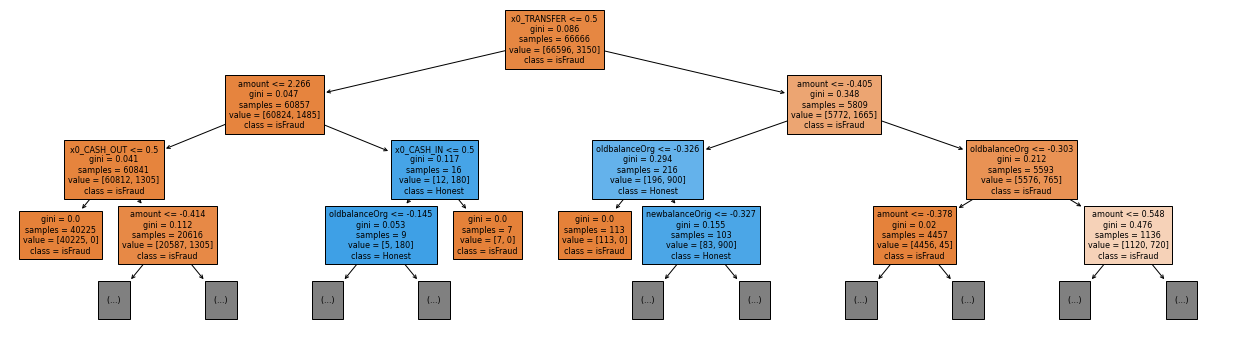

In [19]:
plt.figure(figsize=(22, 6))
plot_tree(model_dt.named_steps["DecisionTreeClassifier"], max_depth=3, filled=True, fontsize=8, feature_names = f_names, 
          class_names=classes);

... e con il metodo *export_text* testualmente.

In [20]:
from sklearn.tree import export_text
print(export_text(model_dt.named_steps["DecisionTreeClassifier"], feature_names=f_names))

|--- x0_TRANSFER <= 0.50
|   |--- amount <= 2.27
|   |   |--- x0_CASH_OUT <= 0.50
|   |   |   |--- class: 0
|   |   |--- x0_CASH_OUT >  0.50
|   |   |   |--- amount <= -0.41
|   |   |   |   |--- oldbalanceOrg <= -0.33
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- oldbalanceOrg >  -0.33
|   |   |   |   |   |--- newbalanceOrig <= -0.33
|   |   |   |   |   |   |--- oldbalanceOrg <= -0.32
|   |   |   |   |   |   |   |--- amount <= -0.44
|   |   |   |   |   |   |   |   |--- amount <= -0.49
|   |   |   |   |   |   |   |   |   |--- oldbalanceOrg <= -0.33
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- oldbalanceOrg >  -0.33
|   |   |   |   |   |   |   |   |   |   |--- amount <= -0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- amount >  -0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- amount >  -0.49
|   |   |   |   |   |   |   

### 4.4 - XGBClassifier

Vediamo se XGBoost, libreria avanzata per fare regressione e classificazione, con la sua classe XGBClassifier può aumentare la precisione del classico modello DecisionTreeClassifier.

In [21]:
#%conda install XGBoost

In [22]:
from xgboost import XGBClassifier 

model_xgb = Pipeline([
    ("preproc", preproc),
    ("XGBClassifier",XGBClassifier(objective='reg:squarederror',n_estimators=50,use_label_encoder = False,random_state=43))
])

model_xgb.fit(X_train, y_train.values.ravel())
print_eval(X_val, y_val, model_xgb, classes)

Confusion Matrix : 
              isFraud     Honest 
   isFraud      33286          2 
    Honest         30         16 

PRECISION  :       0.8889
RECALL     :       0.3478
F1-MEASURE :       0.7498
R^2        :       0.9990


Al punto 5 (Tuning degli Iperparametri) darà, con un pò di lavoro, risultati più soddisfacenti.

## 4.5 - Neural Network

A scopo puramente didattico ho implementato anche una rete neurale per vedere se può risolvere anch'essa il problema di classificazione.

In [23]:
#%conda install TensorFlow

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dropout

X_train_nn = preproc.fit_transform(X_train)
X_val_nn = preproc.transform(X_val)

model_nn = Sequential([
    Dense(32, activation="relu", input_dim=len(f_names)),
    Dense(8, activation="relu"),
    Dense(1)
])
model_nn.summary()
model_nn.compile(optimizer="adam", loss="mse",  metrics=["accuracy"])
fit_history = model_nn.fit(X_train_nn, y_train, batch_size=100, epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
667/667 [==============================] - 1s 1ms/step - loss: 0.0023 - accuracy: 0.9986
Epoch 2/10
667/667 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.9990
Epoch 3/10
667/667 [==============================] - 1s 1ms/step - loss: 0.0010 - accuracy: 0.9990
Epoch 4/10
667/667 [==

In [25]:
loss, acc = model_nn.evaluate(X_val_nn, y_val)
print(f"Loss (MSE) : {loss:5.4f}")
print(f"Accurancy  : {acc:5.4f}")

1042/1042 [==============================] - 1s 987us/step - loss: 0.0014 - accuracy: 0.9986
Loss (MSE) : 0.0014
Accurancy  : 0.9986


Vediamo, in due grafici separati, come varia la loss e l'accuracy al passare delle epoche (iterazioni).

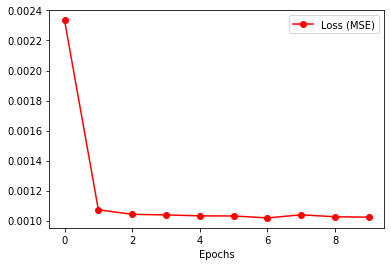

In [26]:
plt.plot(fit_history.history["loss"], "ro-")
plt.legend(["Loss (MSE)"])
plt.xlabel("Epochs");
plt.show();

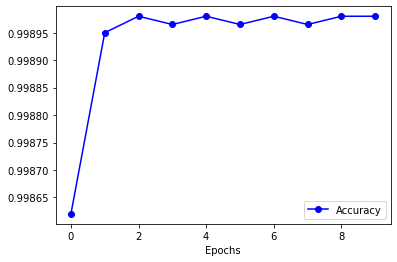

In [27]:
plt.plot(fit_history.history["accuracy"], "bo-")
plt.legend(["Accuracy"])
plt.xlabel("Epochs");
plt.show();

Con la classe di *scikit_learn*, *KerasRegressor*, possiamo usare le potenzialità di Kerar all'interno di una *Pipeline*. Questo ci permette, con qualche accorgimento, di utilizzare *GridSearchCV* e *KFold* per fare *fine-tuning* degli iperparametri di una rete neurali (i.e numero di nodi, batch size, epoche, ecc...).

In [28]:
def build_nn(firstLayerNodes, inpDim):
    model = Sequential([
        Dense(firstLayerNodes, activation="relu", input_dim=len(f_names)),
        Dense(8, activation="relu"),
        Dense(1)
    ])
    model.summary()
    model.compile(optimizer="adam", loss="mse",  metrics=["accuracy"])
    return model

In [29]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold

kf = KFold(3, shuffle=True, random_state=42)

model = Pipeline([
    ("preproc", preproc),
    ("KerasRegressor", KerasRegressor(build_fn=build_nn,
                                      batch_size=100, 
                                      epochs=10,
                                      firstLayerNodes=128, 
                                      inpDim=len(f_names),
                                     )
    )
])

grid = {
    "KerasRegressor__firstLayerNodes": [16, 64, 128]
}

gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train);

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


C:\Users\Federico\AppData\Local\Temp/ipykernel_12744/1925510235.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ("KerasRegressor", KerasRegressor(build_fn=build_nn,


445/445 [==============================] - 1s 1ms/step - loss: 0.0043 - accuracy: 0.9982
Epoch 2/10
445/445 [==============================] - 1s 1ms/step - loss: 0.0010 - accuracy: 0.9990
Epoch 3/10
445/445 [==============================] - 1s 1ms/step - loss: 0.0010 - accuracy: 0.9990
Epoch 4/10
445/445 [==============================] - 1s 1ms/step - loss: 9.9545e-04 - accuracy: 0.9990
Epoch 5/10
445/445 [==============================] - 1s 1ms/step - loss: 9.8665e-04 - accuracy: 0.9990
Epoch 6/10
445/445 [==============================] - 1s 1ms/step - loss: 9.8039e-04 - accuracy: 0.9990
Epoch 7/10
445/445 [==============================] - 1s 1ms/step - loss: 9.7346e-04 - accuracy: 0.9990
Epoch 8/10
445/445 [==============================] - 1s 1ms/step - loss: 9.7053e-04 - accuracy: 0.9990
Epoch 9/10
445/445 [==============================] - 1s 1ms/step - loss: 9.6355e-04 - accuracy: 0.9990
Epoch 10/10
223/223 [==============================] - 0s 1ms/step - loss: 0.0011 - acc

445/445 [==============================] - 1s 1ms/step - loss: 0.0010 - accuracy: 0.9989
Epoch 7/10
445/445 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.9990
Epoch 8/10
445/445 [==============================] - 1s 1ms/step - loss: 0.0010 - accuracy: 0.9990
Epoch 9/10
445/445 [==============================] - 0s 1ms/step - loss: 0.0010 - accuracy: 0.9989
Epoch 10/10
223/223 [==============================] - 0s 1ms/step - loss: 9.4994e-04 - accuracy: 0.9991
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                576       
                                                                 
 dense_19 (Dense)            (None, 8)                 520       
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                      

223/223 [==============================] - 0s 1ms/step - loss: 9.9905e-04 - accuracy: 0.9990
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 16)                144       
                                                                 
 dense_31 (Dense)            (None, 8)                 136       
                                                                 
 dense_32 (Dense)            (None, 1)                 9         
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
667/667 [==============================] - 1s 1ms/step - loss: 0.0025 - accuracy: 0.9989
Epoch 2/10
667/667 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.9990
Epoch 3/10
667/667 [======

In [30]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_KerasRegressor__firstLayerNodes,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.718995,0.101149,0.441182,0.060846,16,{'KerasRegressor__firstLayerNodes': 16},-0.001119,-0.000948,-0.000990,-0.001019,0.000073,1
1,6.240037,0.201849,0.414920,0.040095,64,{'KerasRegressor__firstLayerNodes': 64},-0.001119,-0.000950,-0.001010,-0.001026,0.000070,2
2,6.971444,0.793029,0.349672,0.030111,128,{'KerasRegressor__firstLayerNodes': 128},-0.001108,-0.000977,-0.000999,-0.001028,0.000057,3


## 5 - Tuning degli Iperparametri

Per questa parte utilizziamo una porzione più ampia del datataset e lo suddividiamo in 3 parti e le useremo nel seguente modo :
   - Training Set : Per addestrare i modelli.
   - Validation Set : Per vericare l'accuratteza dei modelli su dati mai visti in fase di training.
   - Test Set : Per calcolare la confidenza.

In [31]:
from sklearn.model_selection import GridSearchCV, KFold
kf = KFold(3, shuffle=True, random_state=42)

transactions = pd.read_csv("../data/data.csv", nrows=1_000_000)
X = transactions[feature_list]
y = transactions[["isFraud"]]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=1/3, random_state=42)

Tra i modelli implementati faccio il "fine-tuning" dei seguenti: 
 - Alberi Decisionali
 - XGBClassifier

Partiamo dal DecisionTreeClassifier e andiamo ad aggiustare i seguenti iperparametri :
 - max_depth : La profondità regola la complessità di un albero, quindi variadola cambia anche l' accuratezza dell'intero modello.
 - min_samples_split : E' usato per regolare il numero minimo di istanze necessarie per uno spit. Anche in questo caso l'iperparametro cambia (indirettamente) la profondità di un albero.

In [32]:
grid = {
    "DecisionTreeClassifier__max_depth": [10, 15, 20],
    "DecisionTreeClassifier__min_samples_split": [5, 10],
}
gs = GridSearchCV(model_dt, grid, cv=kf)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_DecisionTreeClassifier__max_depth,param_DecisionTreeClassifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.966851,0.038925,0.063496,0.009437,20,5,"{'DecisionTreeClassifier__max_depth': 20, 'Dec...",0.999406,0.999440,0.999359,0.999401,0.000033,1
2,1.018475,0.060194,0.068816,0.011016,15,5,"{'DecisionTreeClassifier__max_depth': 15, 'Dec...",0.999372,0.999440,0.999345,0.999386,0.000040,2
5,1.041500,0.028900,0.057514,0.000471,20,10,"{'DecisionTreeClassifier__max_depth': 20, 'Dec...",0.999257,0.999352,0.999230,0.999280,0.000052,3
3,0.947787,0.058639,0.055860,0.000013,15,10,"{'DecisionTreeClassifier__max_depth': 15, 'Dec...",0.999224,0.999352,0.999224,0.999266,0.000060,4
0,1.127412,0.052519,0.065159,0.009646,10,5,"{'DecisionTreeClassifier__max_depth': 10, 'Dec...",0.996605,0.998299,0.997104,0.997336,0.000711,5


In [33]:
gs.best_params_

{'DecisionTreeClassifier__max_depth': 20,
 'DecisionTreeClassifier__min_samples_split': 5}

In [34]:
print_eval(X_val, y_val, gs.best_estimator_, classes)

Confusion Matrix : 
              isFraud     Honest 
   isFraud     333073         97 
    Honest         85         79 

PRECISION  :       0.4489
RECALL     :       0.4817
F1-MEASURE :       0.7322
R^2        :       0.9995


Continuamo con XGBClassifier e ottimizziamo i seguenti iperparametri :
- max_depth : Valgono le stesse considerazioni fatte per il DecisionTreeClassifier .
- reg_lambda : Ho applicato la regolarizzazione L2 delle feature.
- learning_rate $\in$ [0,1] : In questo caso aumentatndo lo step del gradiente raggiungiamo un minimo locale migliore.

In [35]:
grid = [
    {
        "XGBClassifier__learning_rate":[0.6,0.7],
        "XGBClassifier__reg_lambda":[0.5,0.4],
        "XGBClassifier__max_depth":[10,15]
    }
]
gs = GridSearchCV(model_xgb, grid, cv=kf)
gs.fit(X_train, y_train.values.ravel())
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_XGBClassifier__learning_rate,param_XGBClassifier__max_depth,param_XGBClassifier__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,9.178045,0.517258,0.093072,0.003100,0.6,10,0.5,"{'XGBClassifier__learning_rate': 0.6, 'XGBClas...",0.999527,0.999527,0.999480,0.999512,0.000022,1
4,8.062139,0.149209,0.092091,0.002451,0.7,10,0.5,"{'XGBClassifier__learning_rate': 0.7, 'XGBClas...",0.999487,0.999521,0.999521,0.999509,0.000016,2
1,8.599290,0.563979,0.091145,0.002309,0.6,10,0.4,"{'XGBClassifier__learning_rate': 0.6, 'XGBClas...",0.999480,0.999575,0.999460,0.999505,0.000050,3
2,5.211956,0.367057,0.103886,0.002054,0.6,15,0.5,"{'XGBClassifier__learning_rate': 0.6, 'XGBClas...",0.999453,0.999527,0.999453,0.999478,0.000035,4
6,4.433237,0.229011,0.101515,0.001642,0.7,15,0.5,"{'XGBClassifier__learning_rate': 0.7, 'XGBClas...",0.999473,0.999527,0.999386,0.999462,0.000058,5


In [36]:
gs.best_params_

{'XGBClassifier__learning_rate': 0.6,
 'XGBClassifier__max_depth': 10,
 'XGBClassifier__reg_lambda': 0.5}

In [37]:
print_eval(X_val, y_val, gs.best_estimator_, classes)

Confusion Matrix : 
              isFraud     Honest 
   isFraud     333124         46 
    Honest         74         90 

PRECISION  :       0.6618
RECALL     :       0.5488
F1-MEASURE :       0.7999
R^2        :       0.9996


Come possiamo notare la F1-MEASURE è quasi 80%, abbiamo migliorato del $\approx$ 5% il modello XGBClassifier precedente.

## 6 -  Valutazione

Possiamo stimare l'accuratezza sui nuovi dati con il Processo Bernoulliano.

Per trovare $Z_{\alpha/2}$, data una certa confidenza, inizializziamo una mappa dove la chiave è la confidenza e il valore è l'area sottostante la curva di distribuzione normale standard.

In [41]:
Za2_map = {0.99:2.58,0.98:2.33,0.95:1.96,0.90:1.65}

Implementiamo una funzione per calcolare l'intervallo di confidenza.

In [42]:
def bernoulli_process(acc, p_value, N) :
    '''this method calculate the interval confidence based on Bernoulli Process'''
    Za2 = Za2_map[p_value]
    
    num = 2*N*acc+Za2**2
    sqrt = np.sqrt(Za2**2+4*N*acc-4*N*acc**2)
    den = 2*(N+Za2**2)
    
    return (num - Za2*sqrt) / den, (num + Za2*sqrt) / den

Data la confidenza del 95% vediamo l'accuratezza del modello.

In [43]:
accurancy = f1_score(y_test, gs.best_estimator_.predict(X_test), average='macro')
N = X_test.shape[0]
confidence = 0.95
p_min, p_max = bernoulli_process(accurancy, confidence, N)
p_min, p_max, accurancy = p_min * 100, p_max * 100, accurancy * 100
print(f"L'accuratezza del modello migliore è :\n{accurancy:2.2f} % \u00B1 [{p_min:2.2f} %, {p_max:2.2f} %]")

L'accuratezza del modello migliore è :
79.16 % ± [78.99 %, 79.32 %]


## 7 - Resources
Link al dataset di kaggle : https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset